# 实验二：利用torch.nn实现卷积神经网络CNN
姓名：王恩泰

学号：21114019

In [83]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image

## 1. 读取数据集

In [84]:
file_dir = ['./车辆分类数据集/car', './车辆分类数据集/bus', './车辆分类数据集/truck']

num_of_class = 3
batch_size = 8
device = torch.device("cpu")

transform_compose = transforms.Compose( # 串联多个transform操作
    [transforms.Resize([50, 50]),  # 统一图形尺寸
     transforms.ToTensor(), # 转成tensor,ToTensor()能够把灰度范围从0-255变换到0-1之间
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # RGB 3个0.5,transform.Normalize()则把0-1变换到(-1,1), image=(image-mean)/std
])

train_tensor = None
test_tensor = None
train_label = []
test_label = []

# 逐个图片处理
for _dix, _dir in enumerate(file_dir):
    files = os.listdir(_dir) # 获取file list
    number_of_img = len(files) # img数量
    for index, img_file in enumerate(files):
        if img_file.endswith('.jpg'):
            img = Image.open(_dir+'/'+img_file)
            img = img.resize((100,100), Image.ANTIALIAS) # 变形
            img = np.array(img)/255
            img_tensor = torch.from_numpy(img)
            img_tensor = img_tensor.permute(2,1,0) # what means?
            if index < (0.8*number_of_img):
                if train_tensor is None:
                    print(img_tensor.shape)
                    train_tensor = img_tensor.unsqueeze(0)
                    print(train_tensor.shape)
                else:
                    train_tensor = torch.cat((train_tensor, img_tensor.unsqueeze(0)), dim=0)
                train_label.append(_dix)
            else:
                if test_tensor is None:
                    test_tensor = img_tensor.unsqueeze(0)
                else:
                    test_tensor = torch.cat((test_tensor, img_tensor.unsqueeze(0)), dim=0)
                test_label.append(_dix)

train_dataset = Data.TensorDataset(train_tensor, torch.LongTensor(train_label)) # train tensor 和 label tensor组合
test_dataset = Data.TensorDataset(test_tensor, torch.LongTensor(test_label))
train_data_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_data_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

# 这个dataloader同时存了X和y
print(train_tensor.shape)
print(test_tensor.shape) # (数量, 通道, H, W)

torch.Size([3, 100, 100])
torch.Size([1, 3, 100, 100])
torch.Size([1088, 3, 100, 100])
torch.Size([269, 3, 100, 100])


## 2. 利用torch.nn定义卷积过程

In [85]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_class): # 定义函数
        super(ConvModule, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size), # 输出为什么是32通道
            nn.BatchNorm2d(out_channels), # 2维的归一化
            nn.ReLU(inplace=True) # 可以覆盖之前的值
        )
        # 加个全连接层用于预测类别
        self.fc = nn.Linear(out_channels, num_of_class)

    def forward(self, X): # 使用上面定义的向前计算
        out = self.conv(X)
        out = F.avg_pool2d(out, kernel_size=(98,98)) # 这个30的作用？平均数量为1*1
        out = out.squeeze() # 将张量batch*32*1*1 变为batch*32
        out = self.fc(out)
        return out

## 5. 训练及测试

In [86]:
def train_epoch(net, data_loader, device): # 一个epoch的程序
    net.train() # 训练模式
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0 # 正确分类样本个数
    sample_num = 0 # 样本总数

    for batch_idx, (x_train, y_train) in enumerate(data_loader):
        x_train = x_train.to(device).float()
        y_train = y_train.to(device).long() # 因为预测出来是long的
        
        optimizer.zero_grad()
        y_predict = net(x_train)
        # print(y_train)
        # print(y_predict)
        loss = criterion(y_predict, y_train)
        loss.backward()
        optimizer.step() # 更新参数

        total_loss += loss.item()
        prediction = torch.argmax(y_predict, 1)
        correct += (prediction == y_train).sum().item()
        sample_num += len(prediction)
    loss = total_loss / len(train_dataset)
    acc = correct / len(train_dataset)
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (x_test, y_test) in enumerate(data_loader):
            x_test = x_test.to(device).float()
            y_test = y_test.to(device).long()
            y_predict = net(x_test)
            loss = criterion(y_predict, y_test)

            total_loss += loss.item()
            prediction = torch.argmax(y_predict, 1)
            correct += (prediction == y_test).sum().item()
            sample_num += len(prediction)
    loss = total_loss / len(test_dataset)
    acc = correct / len(test_dataset)
    return loss, acc

## 6. 主函数

epoch: 0	 train_loss: 0.1123 	train_acc: 0.6213 	test_loss: 0.1586	 test_acc: 0.1673
epoch: 1	 train_loss: 0.0932 	train_acc: 0.7077 	test_loss: 0.1791	 test_acc: 0.2119
epoch: 2	 train_loss: 0.0892 	train_acc: 0.7206 	test_loss: 0.2163	 test_acc: 0.2119
epoch: 3	 train_loss: 0.0887 	train_acc: 0.7371 	test_loss: 0.2128	 test_acc: 0.1599
epoch: 4	 train_loss: 0.0837 	train_acc: 0.7785 	test_loss: 0.2322	 test_acc: 0.1747
epoch: 5	 train_loss: 0.0814 	train_acc: 0.7739 	test_loss: 0.2788	 test_acc: 0.2677
epoch: 6	 train_loss: 0.0823 	train_acc: 0.7923 	test_loss: 0.1990	 test_acc: 0.2714
epoch: 7	 train_loss: 0.0832 	train_acc: 0.7831 	test_loss: 0.2253	 test_acc: 0.2677
epoch: 8	 train_loss: 0.0802 	train_acc: 0.7840 	test_loss: 0.2473	 test_acc: 0.2119
epoch: 9	 train_loss: 0.0808 	train_acc: 0.7803 	test_loss: 0.2258	 test_acc: 0.2714
epoch: 10	 train_loss: 0.0797 	train_acc: 0.8051 	test_loss: 0.2526	 test_acc: 0.2565
epoch: 11	 train_loss: 0.0765 	train_acc: 0.8244 	test_loss: 0.2

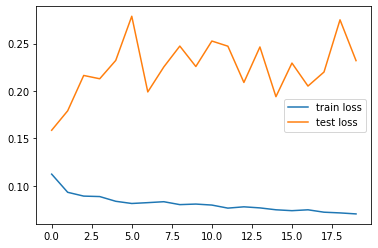

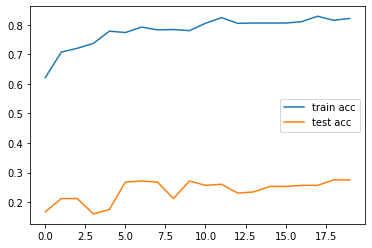

In [87]:
epochs = 20
lr = 0.001
# batch_size = 128
device = torch.device("cpu")

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# 声明net model
net = ConvModule(3, 32, 3, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, train_data_loader, device)
    test_loss, test_acc = test_epoch(net, test_data_loader, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch}\t train_loss: {train_loss:.4f} \t" f"train_acc: {train_acc:.4f} \t"
         f"test_loss: {test_loss:.4f}\t test_acc: {test_acc:.4f}")        


plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show()     
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show()    